## Correlation
Correlation algorithm is widely used in astronomical signal processing area, for example: aperture synthesis imaging, Stokes calculation in a dual polariztion receiver,  phase calibration for Phased-Array-Feed receiver, phase measurement in microwave holography and etc.
### Aperture Synthesis Imaging 
Aperture synthesis enables us to map the sky brightness using arrays of radio antennas.  Measurements of the cross correlation of signals between pairs of antennas sample the coherence or visibility function of the wavefront. If the dimensions of the radio source and the telescope array are small compared with the distance to the source, then the coherence of the wavefront is proportional to the Fourier transform of the intensity
distribution of the source (Van Cittert-Zernike theorem, Born \& Wolf,
1959).

A telescope array with N antennas, provides N(N-1)/2 cross correlations and N auto correlations for each polarization product. Earth's rotation of  the projected geometry of the telescope array in the direction of a celestial source provides additional samples of the source visibility function in the aperture plane (Ryle, 1962).For example, if we have 3 antennas, A, B and C, we need to perform correlation across each pair, so the number of cross correlation is 3, which are AB, AC and BC. And the number of auto-correlation is 3, ie AA, BB, CC, which will give us the power in each signal. We will see an example later. The complexity of this calculation scales with the number of antennas squared. Furthermore, it is a difficult signal routing problem since every antenna must be able to exchange data with every other antenna.
### Polarization Correlation
Dish type receivers are typically dual polarized (horizontal and vertical feeds). Each polarization is fed into separate ADC inputs. When correlating these antenna, we differentiate between full Stokes correlation or a half Stokes method. A full Stokes correlator does cross correlation between the different polarizations (ie for a given two antennas, A and B, it multiplies the horizontal feed from A with the vertical feed from B and vice-versa). A half stokes correlator only correlates like polarizations with each other, thereby halving the compute requirements. 

### Phase Measurement
Phase difference between two signals can be detected by cross-correlation, this method has been widely used in meteorology, computing and communications. And this technique can be imported in astronomy for phase measurement of microwave Holography, phase calibration for PAF receiver and so on. For example, there are two signals A and B, the cross correlation resultes are AA, AB_real,AB_imag, BB, the phase information can be calculated by $phase = arctan(\frac{AB\_imag}{AB\_real})$.

In [40]:
%matplotlib inline

In [41]:
# Import required modules
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.signal import firwin, freqz, lfilter
import seaborn as sns
sns.set_style("white")
def db(x):
    """ Convert linear value to dB value """
    return 10*np.log10(x)

Let's define a poly phase filterbank function first.

In [27]:
def pfb_fir_frontend(x, win_coeffs, M, P):
    W = x.shape[0] // M // P
    x_p = x.reshape((W*M, P)).T
    h_p = win_coeffs.reshape((M, P)).T
    x_summed = np.zeros((P, M * W - M))
    for t in range(0, M*W-M):
        x_weighted = x_p[:, t:t+M] * h_p
        x_summed[:, t] = x_weighted.sum(axis=1)
    return x_summed.T

Generate window coefficients for PFB.

In [28]:
def generate_win_coeffs(M, P, window_fn="hamming"):
    win_coeffs = scipy.signal.get_window(window_fn, M*P)
    sinc       = scipy.signal.firwin(M * P, cutoff=1.0/P, window="rectangular")
    #sinc       = scipy.signal.firwin(M * P, cutoff=1.0/P, window="hamming")
    win_coeffs *= sinc
    return win_coeffs

Fourier transfomation function, return complex value.

In [29]:
def fft(x_p, P, axis=1):
    return np.fft.fft(x_p, P, axis=axis)

This is the main function for two signals correlation. Transfer two signals x and y in this function with number of taps, number of channels, number of integrations and wiondow function, return xx, yy, xy_real and xy_image.

In [30]:
    def correlator(x,y,n_taps, n_chan, n_int, window_fn="hamming"):
        M = n_taps
        P = n_chan 

        # Generate window coefficients
        win_coeffs = generate_win_coeffs(M, P, window_fn)  

        # Apply frontend, take FFT
        x_pfb = pfb_fir_frontend(x, win_coeffs, M, P)
        x_fft = fft(x_pfb, P)
        y_pfb = pfb_fir_frontend(y, win_coeffs, M, P)
        y_fft = fft(y_pfb, P)

        # Perform cross correlation
        xx = x_fft.real**2    
        yy = y_fft.real**2
        xy_real =  x_fft.real * y_fft.real
        xy_imag = x_fft.imag * y_fft.imag

        # Trim array so we can do time integration
        xx = xx[:np.round(xx.shape[0]//n_int)*n_int]
        yy = yy[:np.round(yy.shape[0]//n_int)*n_int]
        xy_real = xy_real[:np.round(xy_real.shape[0]//n_int)*n_int]
        xy_imag = xy_imag[:np.round(xy_imag.shape[0]//n_int)*n_int]

        # Integrate over time, by reshaping and summing over axis (efficient)
        xx = xx.reshape(xx.shape[0]//n_int, n_int, xx.shape[1])
        xx = xx.mean(axis=1)

        yy = yy.reshape(yy.shape[0]//n_int, n_int, yy.shape[1])
        yy = yy.mean(axis=1)

        xy_real = xy_real.reshape(xy_real.shape[0]//n_int, n_int, xy_real.shape[1])
        xy_real = xy_real.mean(axis=1)

        xy_imag = xy_imag.reshape(xy_imag.shape[0]//n_int, n_int, xy_imag.shape[1])
        xy_imag = xy_imag.mean(axis=1)

        return xx,yy,xy_real,xy_imag
    


Generate two sinwave signals mixed with noise.

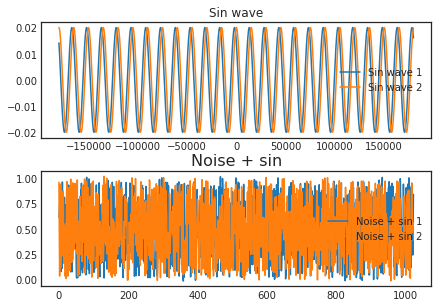

In [35]:
M     = 4          # Number of taps
P     = 1024       # Number of 'branches', also fft length
W     = 1000       # Number of windows of length M*P in input time stream
#n_int = 2          # Number of time integrations on output data

samples = np.arange(-1.0,1.0,2.0/P)

noise1   = np.random.random(M*P*W) 
noise2   = np.random.random(M*P*W) 
freq = 500

amp  = 0.02

phase1 = np.pi/4
phase2 = np.pi/2

cw_signal1 = M*W*(amp*np.sin(2*np.pi*samples*freq+phase1)).tolist()
cw_signal2 = M*W*(amp*np.sin(2*np.pi*samples*freq+phase2)).tolist()

data1 = noise1 + cw_signal1
data2 = noise2 + cw_signal2


plt.subplot(2,1,1)
plt.title("Sin wave")
plt.plot(samples[:1024]*360*freq,cw_signal1[:1024],label='Sin wave 1')
plt.plot(samples[:1024]*360*freq,cw_signal2[:1024],label='Sin wave 2')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.legend()
plt.subplot(2,1,2)
plt.title("Noise + sin",fontsize=16)
plt.plot(data1[:1024],label='Noise + sin 1')
plt.plot(data2[:1024],label='Noise + sin 2')
plt.legend()


Call correlation function and plot the result.

/home/peix/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/peix/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


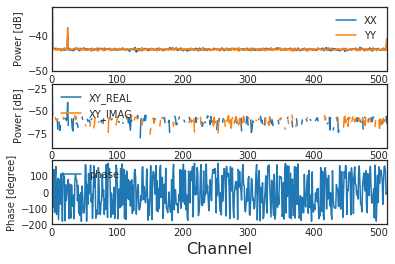

In [32]:
XX,YY,XY_REAL,XY_IMAG = correlator(data1,data2, n_taps=M, n_chan=P, n_int=1000, window_fn="hamming")

plt.subplot(3,1,1)
plt.plot(db(XX[0]), label='XX')
plt.plot(db(YY[0]), label='YY')
plt.ylim(-50, -32)
plt.xlim(0, P/2)
plt.xlabel("Channel",fontsize=16)
plt.ylabel("Power [dB]")
plt.legend()

plt.subplot(3,1,2)
plt.plot(db(XY_REAL[0]), label='XY_REAL')
plt.plot(db(XY_IMAG[0]), label='XY_IMAG')
plt.ylim(-90, -20)
plt.xlim(0, P/2)
plt.xlabel("Channel",fontsize=16)
plt.ylabel("Power [dB]")
plt.legend()

phase = len(XY_REAL[0])*[0]
for i in range(len(XY_REAL[0])):
    phase[i] = np.angle(complex(XY_REAL[0][i],XY_IMAG[0][i]))/np.pi*180.0
    
plt.subplot(3,1,3)
plt.plot(phase,label='phase')
plt.xlim(0, P/2)
plt.xlabel("Channel",fontsize=16)
plt.ylabel("Phase [degree]")
plt.legend()